# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 1.0809
Epoch 1/200, Iteration 2/12, Loss: 0.4397
Epoch 1/200, Iteration 3/12, Loss: 0.9093
Epoch 1/200, Iteration 4/12, Loss: 0.2742
Epoch 1/200, Iteration 5/12, Loss: 0.2894
Epoch 1/200, Iteration 6/12, Loss: 0.3792
Epoch 1/200, Iteration 7/12, Loss: 0.4121
Epoch 1/200, Iteration 8/12, Loss: 0.2122
Epoch 1/200, Iteration 9/12, Loss: 0.2066
Epoch 1/200, Iteration 10/12, Loss: 0.1368
Epoch 1/200, Iteration 11/12, Loss: 0.1156
Epoch 1/200, Iteration 12/12, Loss: 0.1266
Epoch 1/200, Iteration 13/12, Loss: 0.0966
Train Error: 
 Accuracy: 46.25%, Avg loss: 0.092619, MRE: 0.165280, MAE: 0.030803 

Test Error: 
 Accuracy: 47.5%, Avg loss: 0.070560, MRE: 0.146542, MAE: 0.028531 

Epoch 2/200, Iteration 1/12, Loss: 0.0820
Epoch 2/200, Iteration 2/12, Loss: 0.0948
Epoch 2/200, Iteration 3/12, Loss: 0.1436
Epoch 2/200, Iteration 4/12, Loss: 0.0839
Epoch 2/200, Iteration 5/12, Loss: 0.0647
Epoch 2/200, Iteration 6/12, Loss: 0.0665
Epoch 2/200, Iteration 7/12, Los

Epoch 12/200, Iteration 10/12, Loss: 0.0016
Epoch 12/200, Iteration 11/12, Loss: 0.0025
Epoch 12/200, Iteration 12/12, Loss: 0.0034
Epoch 12/200, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.002996, MRE: 0.036366, MAE: 0.006214 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002478, MRE: 0.027752, MAE: 0.005786 

Epoch 13/200, Iteration 1/12, Loss: 0.0023
Epoch 13/200, Iteration 2/12, Loss: 0.0043
Epoch 13/200, Iteration 3/12, Loss: 0.0010
Epoch 13/200, Iteration 4/12, Loss: 0.0102
Epoch 13/200, Iteration 5/12, Loss: 0.0016
Epoch 13/200, Iteration 6/12, Loss: 0.0038
Epoch 13/200, Iteration 7/12, Loss: 0.0107
Epoch 13/200, Iteration 8/12, Loss: 0.0015
Epoch 13/200, Iteration 9/12, Loss: 0.0097
Epoch 13/200, Iteration 10/12, Loss: 0.0049
Epoch 13/200, Iteration 11/12, Loss: 0.0012
Epoch 13/200, Iteration 12/12, Loss: 0.0017
Epoch 13/200, Iteration 13/12, Loss: 0.0080
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.002452, MRE: 0.024087, MAE: 0.004422 

Test Error: 

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005452, MRE: 0.028894, MAE: 0.007903 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.004710, MRE: 0.026119, MAE: 0.007823 

Epoch 24/200, Iteration 1/12, Loss: 0.0066
Epoch 24/200, Iteration 2/12, Loss: 0.0027
Epoch 24/200, Iteration 3/12, Loss: 0.0057
Epoch 24/200, Iteration 4/12, Loss: 0.0046
Epoch 24/200, Iteration 5/12, Loss: 0.0075
Epoch 24/200, Iteration 6/12, Loss: 0.0033
Epoch 24/200, Iteration 7/12, Loss: 0.0040
Epoch 24/200, Iteration 8/12, Loss: 0.0055
Epoch 24/200, Iteration 9/12, Loss: 0.0036
Epoch 24/200, Iteration 10/12, Loss: 0.0071
Epoch 24/200, Iteration 11/12, Loss: 0.0067
Epoch 24/200, Iteration 12/12, Loss: 0.0036
Epoch 24/200, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 82.62%, Avg loss: 0.007266, MRE: 0.037939, MAE: 0.007350 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.006169, MRE: 0.032320, MAE: 0.006273 

Epoch 25/200, Iteration 1/12, Loss: 0.0069
Epoch 25/200, Iteration 2/12, Loss: 0.0046
Epoch 25/200, Itera

Epoch 35/200, Iteration 7/12, Loss: 0.0003
Epoch 35/200, Iteration 8/12, Loss: 0.0003
Epoch 35/200, Iteration 9/12, Loss: 0.0003
Epoch 35/200, Iteration 10/12, Loss: 0.0004
Epoch 35/200, Iteration 11/12, Loss: 0.0004
Epoch 35/200, Iteration 12/12, Loss: 0.0003
Epoch 35/200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000282, MRE: 0.009040, MAE: 0.001484 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000261, MRE: 0.006971, MAE: 0.001508 

Epoch 36/200, Iteration 1/12, Loss: 0.0003
Epoch 36/200, Iteration 2/12, Loss: 0.0004
Epoch 36/200, Iteration 3/12, Loss: 0.0001
Epoch 36/200, Iteration 4/12, Loss: 0.0004
Epoch 36/200, Iteration 5/12, Loss: 0.0006
Epoch 36/200, Iteration 6/12, Loss: 0.0004
Epoch 36/200, Iteration 7/12, Loss: 0.0005
Epoch 36/200, Iteration 8/12, Loss: 0.0004
Epoch 36/200, Iteration 9/12, Loss: 0.0002
Epoch 36/200, Iteration 10/12, Loss: 0.0004
Epoch 36/200, Iteration 11/12, Loss: 0.0002
Epoch 36/200, Iteration 12/12, Loss: 0.0002
Epoch 36/

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000132, MRE: 0.008604, MAE: 0.000963 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000129, MRE: 0.004802, MAE: 0.001000 

Epoch 47/200, Iteration 1/12, Loss: 0.0001
Epoch 47/200, Iteration 2/12, Loss: 0.0001
Epoch 47/200, Iteration 3/12, Loss: 0.0001
Epoch 47/200, Iteration 4/12, Loss: 0.0003
Epoch 47/200, Iteration 5/12, Loss: 0.0002
Epoch 47/200, Iteration 6/12, Loss: 0.0001
Epoch 47/200, Iteration 7/12, Loss: 0.0001
Epoch 47/200, Iteration 8/12, Loss: 0.0001
Epoch 47/200, Iteration 9/12, Loss: 0.0001
Epoch 47/200, Iteration 10/12, Loss: 0.0001
Epoch 47/200, Iteration 11/12, Loss: 0.0001
Epoch 47/200, Iteration 12/12, Loss: 0.0001
Epoch 47/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000123, MRE: 0.008224, MAE: 0.000928 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000117, MRE: 0.004625, MAE: 0.000935 

Epoch 48/200, Iteration 1/12, Loss: 0.0001
Epoch 48/200, Iteration 2/12, Loss: 0.0001
Epoch 48/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000109, MRE: 0.006381, MAE: 0.000879 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000095, MRE: 0.004254, MAE: 0.000867 

Epoch 59/200, Iteration 1/12, Loss: 0.0002
Epoch 59/200, Iteration 2/12, Loss: 0.0001
Epoch 59/200, Iteration 3/12, Loss: 0.0000
Epoch 59/200, Iteration 4/12, Loss: 0.0002
Epoch 59/200, Iteration 5/12, Loss: 0.0001
Epoch 59/200, Iteration 6/12, Loss: 0.0001
Epoch 59/200, Iteration 7/12, Loss: 0.0001
Epoch 59/200, Iteration 8/12, Loss: 0.0001
Epoch 59/200, Iteration 9/12, Loss: 0.0001
Epoch 59/200, Iteration 10/12, Loss: 0.0001
Epoch 59/200, Iteration 11/12, Loss: 0.0002
Epoch 59/200, Iteration 12/12, Loss: 0.0001
Epoch 59/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000089, MRE: 0.006040, MAE: 0.000807 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000090, MRE: 0.003886, MAE: 0.000757 

Epoch 60/200, Iteration 1/12, Loss: 0.0001
Epoch 60/200, Iteration 2/12, Loss: 0.0001
Epoch 60/200, Ite

Epoch 70/200, Iteration 7/12, Loss: 0.0001
Epoch 70/200, Iteration 8/12, Loss: 0.0001
Epoch 70/200, Iteration 9/12, Loss: 0.0001
Epoch 70/200, Iteration 10/12, Loss: 0.0001
Epoch 70/200, Iteration 11/12, Loss: 0.0001
Epoch 70/200, Iteration 12/12, Loss: 0.0001
Epoch 70/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000084, MRE: 0.005879, MAE: 0.000780 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000088, MRE: 0.003902, MAE: 0.000711 

Epoch 71/200, Iteration 1/12, Loss: 0.0001
Epoch 71/200, Iteration 2/12, Loss: 0.0001
Epoch 71/200, Iteration 3/12, Loss: 0.0001
Epoch 71/200, Iteration 4/12, Loss: 0.0001
Epoch 71/200, Iteration 5/12, Loss: 0.0001
Epoch 71/200, Iteration 6/12, Loss: 0.0001
Epoch 71/200, Iteration 7/12, Loss: 0.0001
Epoch 71/200, Iteration 8/12, Loss: 0.0001
Epoch 71/200, Iteration 9/12, Loss: 0.0001
Epoch 71/200, Iteration 10/12, Loss: 0.0001
Epoch 71/200, Iteration 11/12, Loss: 0.0001
Epoch 71/200, Iteration 12/12, Loss: 0.0001
Epoch 71/

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000060, MRE: 0.005481, MAE: 0.000675 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000063, MRE: 0.003426, MAE: 0.000641 

Epoch 82/200, Iteration 1/12, Loss: 0.0001
Epoch 82/200, Iteration 2/12, Loss: 0.0000
Epoch 82/200, Iteration 3/12, Loss: 0.0001
Epoch 82/200, Iteration 4/12, Loss: 0.0000
Epoch 82/200, Iteration 5/12, Loss: 0.0000
Epoch 82/200, Iteration 6/12, Loss: 0.0000
Epoch 82/200, Iteration 7/12, Loss: 0.0001
Epoch 82/200, Iteration 8/12, Loss: 0.0001
Epoch 82/200, Iteration 9/12, Loss: 0.0002
Epoch 82/200, Iteration 10/12, Loss: 0.0001
Epoch 82/200, Iteration 11/12, Loss: 0.0001
Epoch 82/200, Iteration 12/12, Loss: 0.0001
Epoch 82/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000088, MRE: 0.005685, MAE: 0.000774 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000079, MRE: 0.003465, MAE: 0.000667 

Epoch 83/200, Iteration 1/12, Loss: 0.0000
Epoch 83/200, Iteration 2/12, Loss: 0.0001
Epoch 83/200, Ite

Epoch 93/200, Iteration 7/12, Loss: 0.0001
Epoch 93/200, Iteration 8/12, Loss: 0.0001
Epoch 93/200, Iteration 9/12, Loss: 0.0000
Epoch 93/200, Iteration 10/12, Loss: 0.0001
Epoch 93/200, Iteration 11/12, Loss: 0.0001
Epoch 93/200, Iteration 12/12, Loss: 0.0001
Epoch 93/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000052, MRE: 0.005090, MAE: 0.000621 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000053, MRE: 0.003023, MAE: 0.000585 

Epoch 94/200, Iteration 1/12, Loss: 0.0000
Epoch 94/200, Iteration 2/12, Loss: 0.0000
Epoch 94/200, Iteration 3/12, Loss: 0.0000
Epoch 94/200, Iteration 4/12, Loss: 0.0001
Epoch 94/200, Iteration 5/12, Loss: 0.0001
Epoch 94/200, Iteration 6/12, Loss: 0.0001
Epoch 94/200, Iteration 7/12, Loss: 0.0001
Epoch 94/200, Iteration 8/12, Loss: 0.0001
Epoch 94/200, Iteration 9/12, Loss: 0.0001
Epoch 94/200, Iteration 10/12, Loss: 0.0001
Epoch 94/200, Iteration 11/12, Loss: 0.0001
Epoch 94/200, Iteration 12/12, Loss: 0.0000
Epoch 94/

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.005302, MAE: 0.000675 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000058, MRE: 0.003280, MAE: 0.000643 

Epoch 105/200, Iteration 1/12, Loss: 0.0001
Epoch 105/200, Iteration 2/12, Loss: 0.0000
Epoch 105/200, Iteration 3/12, Loss: 0.0000
Epoch 105/200, Iteration 4/12, Loss: 0.0000
Epoch 105/200, Iteration 5/12, Loss: 0.0000
Epoch 105/200, Iteration 6/12, Loss: 0.0000
Epoch 105/200, Iteration 7/12, Loss: 0.0001
Epoch 105/200, Iteration 8/12, Loss: 0.0001
Epoch 105/200, Iteration 9/12, Loss: 0.0000
Epoch 105/200, Iteration 10/12, Loss: 0.0001
Epoch 105/200, Iteration 11/12, Loss: 0.0000
Epoch 105/200, Iteration 12/12, Loss: 0.0001
Epoch 105/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000058, MRE: 0.005251, MAE: 0.000720 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000066, MRE: 0.003580, MAE: 0.000746 

Epoch 106/200, Iteration 1/12, Loss: 0.0000
Epoch 106/200, Iteration 2/12, Loss: 0.0000
Ep

Epoch 116/200, Iteration 6/12, Loss: 0.0000
Epoch 116/200, Iteration 7/12, Loss: 0.0000
Epoch 116/200, Iteration 8/12, Loss: 0.0000
Epoch 116/200, Iteration 9/12, Loss: 0.0000
Epoch 116/200, Iteration 10/12, Loss: 0.0001
Epoch 116/200, Iteration 11/12, Loss: 0.0000
Epoch 116/200, Iteration 12/12, Loss: 0.0000
Epoch 116/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000041, MRE: 0.004959, MAE: 0.000575 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.002996, MAE: 0.000576 

Epoch 117/200, Iteration 1/12, Loss: 0.0000
Epoch 117/200, Iteration 2/12, Loss: 0.0000
Epoch 117/200, Iteration 3/12, Loss: 0.0000
Epoch 117/200, Iteration 4/12, Loss: 0.0001
Epoch 117/200, Iteration 5/12, Loss: 0.0000
Epoch 117/200, Iteration 6/12, Loss: 0.0000
Epoch 117/200, Iteration 7/12, Loss: 0.0000
Epoch 117/200, Iteration 8/12, Loss: 0.0000
Epoch 117/200, Iteration 9/12, Loss: 0.0001
Epoch 117/200, Iteration 10/12, Loss: 0.0000
Epoch 117/200, Iteration 11/12, Loss

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.005278, MAE: 0.000700 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000054, MRE: 0.003518, MAE: 0.000665 

Epoch 128/200, Iteration 1/12, Loss: 0.0000
Epoch 128/200, Iteration 2/12, Loss: 0.0000
Epoch 128/200, Iteration 3/12, Loss: 0.0000
Epoch 128/200, Iteration 4/12, Loss: 0.0000
Epoch 128/200, Iteration 5/12, Loss: 0.0000
Epoch 128/200, Iteration 6/12, Loss: 0.0001
Epoch 128/200, Iteration 7/12, Loss: 0.0000
Epoch 128/200, Iteration 8/12, Loss: 0.0000
Epoch 128/200, Iteration 9/12, Loss: 0.0000
Epoch 128/200, Iteration 10/12, Loss: 0.0000
Epoch 128/200, Iteration 11/12, Loss: 0.0001
Epoch 128/200, Iteration 12/12, Loss: 0.0001
Epoch 128/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000042, MRE: 0.004670, MAE: 0.000568 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000045, MRE: 0.002926, MAE: 0.000619 

Epoch 129/200, Iteration 1/12, Loss: 0.0001
Epoch 129/200, Iteration 2/12, Loss: 0.0001
Ep

Epoch 139/200, Iteration 8/12, Loss: 0.0000
Epoch 139/200, Iteration 9/12, Loss: 0.0000
Epoch 139/200, Iteration 10/12, Loss: 0.0000
Epoch 139/200, Iteration 11/12, Loss: 0.0000
Epoch 139/200, Iteration 12/12, Loss: 0.0000
Epoch 139/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.004846, MAE: 0.000549 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000042, MRE: 0.003004, MAE: 0.000568 

Epoch 140/200, Iteration 1/12, Loss: 0.0000
Epoch 140/200, Iteration 2/12, Loss: 0.0001
Epoch 140/200, Iteration 3/12, Loss: 0.0001
Epoch 140/200, Iteration 4/12, Loss: 0.0000
Epoch 140/200, Iteration 5/12, Loss: 0.0000
Epoch 140/200, Iteration 6/12, Loss: 0.0000
Epoch 140/200, Iteration 7/12, Loss: 0.0000
Epoch 140/200, Iteration 8/12, Loss: 0.0000
Epoch 140/200, Iteration 9/12, Loss: 0.0000
Epoch 140/200, Iteration 10/12, Loss: 0.0000
Epoch 140/200, Iteration 11/12, Loss: 0.0000
Epoch 140/200, Iteration 12/12, Loss: 0.0001
Epoch 140/200, Iteration 13/12, Lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000033, MRE: 0.004481, MAE: 0.000503 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000035, MRE: 0.002760, MAE: 0.000530 

Epoch 151/200, Iteration 1/12, Loss: 0.0000
Epoch 151/200, Iteration 2/12, Loss: 0.0000
Epoch 151/200, Iteration 3/12, Loss: 0.0000
Epoch 151/200, Iteration 4/12, Loss: 0.0001
Epoch 151/200, Iteration 5/12, Loss: 0.0000
Epoch 151/200, Iteration 6/12, Loss: 0.0000
Epoch 151/200, Iteration 7/12, Loss: 0.0000
Epoch 151/200, Iteration 8/12, Loss: 0.0001
Epoch 151/200, Iteration 9/12, Loss: 0.0001
Epoch 151/200, Iteration 10/12, Loss: 0.0000
Epoch 151/200, Iteration 11/12, Loss: 0.0000
Epoch 151/200, Iteration 12/12, Loss: 0.0001
Epoch 151/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.004741, MAE: 0.000624 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000043, MRE: 0.003034, MAE: 0.000672 

Epoch 152/200, Iteration 1/12, Loss: 0.0001
Epoch 152/200, Iteration 2/12, Loss: 0.0001
Ep

Epoch 162/200, Iteration 6/12, Loss: 0.0000
Epoch 162/200, Iteration 7/12, Loss: 0.0000
Epoch 162/200, Iteration 8/12, Loss: 0.0000
Epoch 162/200, Iteration 9/12, Loss: 0.0000
Epoch 162/200, Iteration 10/12, Loss: 0.0000
Epoch 162/200, Iteration 11/12, Loss: 0.0000
Epoch 162/200, Iteration 12/12, Loss: 0.0000
Epoch 162/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000030, MRE: 0.004353, MAE: 0.000503 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000029, MRE: 0.002611, MAE: 0.000482 

Epoch 163/200, Iteration 1/12, Loss: 0.0000
Epoch 163/200, Iteration 2/12, Loss: 0.0000
Epoch 163/200, Iteration 3/12, Loss: 0.0001
Epoch 163/200, Iteration 4/12, Loss: 0.0000
Epoch 163/200, Iteration 5/12, Loss: 0.0000
Epoch 163/200, Iteration 6/12, Loss: 0.0000
Epoch 163/200, Iteration 7/12, Loss: 0.0000
Epoch 163/200, Iteration 8/12, Loss: 0.0000
Epoch 163/200, Iteration 9/12, Loss: 0.0000
Epoch 163/200, Iteration 10/12, Loss: 0.0000
Epoch 163/200, Iteration 11/12, Loss

Epoch 173/200, Iteration 7/12, Loss: 0.0000
Epoch 173/200, Iteration 8/12, Loss: 0.0000
Epoch 173/200, Iteration 9/12, Loss: 0.0000
Epoch 173/200, Iteration 10/12, Loss: 0.0000
Epoch 173/200, Iteration 11/12, Loss: 0.0000
Epoch 173/200, Iteration 12/12, Loss: 0.0000
Epoch 173/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000029, MRE: 0.004228, MAE: 0.000524 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000035, MRE: 0.002912, MAE: 0.000563 

Epoch 174/200, Iteration 1/12, Loss: 0.0000
Epoch 174/200, Iteration 2/12, Loss: 0.0000
Epoch 174/200, Iteration 3/12, Loss: 0.0000
Epoch 174/200, Iteration 4/12, Loss: 0.0000
Epoch 174/200, Iteration 5/12, Loss: 0.0000
Epoch 174/200, Iteration 6/12, Loss: 0.0000
Epoch 174/200, Iteration 7/12, Loss: 0.0000
Epoch 174/200, Iteration 8/12, Loss: 0.0000
Epoch 174/200, Iteration 9/12, Loss: 0.0001
Epoch 174/200, Iteration 10/12, Loss: 0.0000
Epoch 174/200, Iteration 11/12, Loss: 0.0000
Epoch 174/200, Iteration 12/12, Los

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000019, MRE: 0.003664, MAE: 0.000375 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.002148, MAE: 0.000412 

Epoch 185/200, Iteration 1/12, Loss: 0.0000
Epoch 185/200, Iteration 2/12, Loss: 0.0000
Epoch 185/200, Iteration 3/12, Loss: 0.0000
Epoch 185/200, Iteration 4/12, Loss: 0.0000
Epoch 185/200, Iteration 5/12, Loss: 0.0000
Epoch 185/200, Iteration 6/12, Loss: 0.0000
Epoch 185/200, Iteration 7/12, Loss: 0.0000
Epoch 185/200, Iteration 8/12, Loss: 0.0000
Epoch 185/200, Iteration 9/12, Loss: 0.0000
Epoch 185/200, Iteration 10/12, Loss: 0.0000
Epoch 185/200, Iteration 11/12, Loss: 0.0000
Epoch 185/200, Iteration 12/12, Loss: 0.0000
Epoch 185/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000019, MRE: 0.003686, MAE: 0.000377 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.002140, MAE: 0.000414 

Epoch 186/200, Iteration 1/12, Loss: 0.0000
Epoch 186/200, Iteration 2/12, Loss: 0.0000
Ep

Epoch 196/200, Iteration 7/12, Loss: 0.0000
Epoch 196/200, Iteration 8/12, Loss: 0.0000
Epoch 196/200, Iteration 9/12, Loss: 0.0000
Epoch 196/200, Iteration 10/12, Loss: 0.0000
Epoch 196/200, Iteration 11/12, Loss: 0.0000
Epoch 196/200, Iteration 12/12, Loss: 0.0000
Epoch 196/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000018, MRE: 0.003683, MAE: 0.000375 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.002129, MAE: 0.000416 

Epoch 197/200, Iteration 1/12, Loss: 0.0000
Epoch 197/200, Iteration 2/12, Loss: 0.0000
Epoch 197/200, Iteration 3/12, Loss: 0.0000
Epoch 197/200, Iteration 4/12, Loss: 0.0000
Epoch 197/200, Iteration 5/12, Loss: 0.0000
Epoch 197/200, Iteration 6/12, Loss: 0.0000
Epoch 197/200, Iteration 7/12, Loss: 0.0000
Epoch 197/200, Iteration 8/12, Loss: 0.0000
Epoch 197/200, Iteration 9/12, Loss: 0.0000
Epoch 197/200, Iteration 10/12, Loss: 0.0000
Epoch 197/200, Iteration 11/12, Loss: 0.0000
Epoch 197/200, Iteration 12/12, Los

#### Plots loss vs Epoch

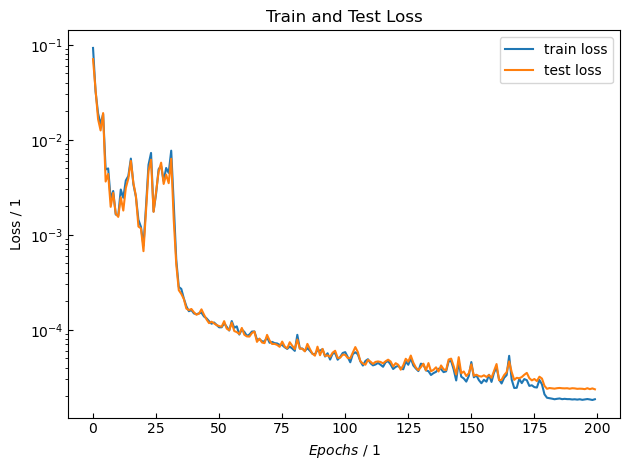

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999861482035588 , R^2(NH3) = 0.9999766903894297
Test Dataset: R^2(H2) = 0.999984023503617 , R^2(NH3) = 0.9999693683188975
Max Error Training: |x_H2 - x_H2,pred| = 0.009233199172058948 , |x_NH3 - x_NH3,pred| = 0.0030571802007879623
Max Error Test: |x_H2 - x_H2,pred| = 0.004511118614641263 , |x_NH3 - x_NH3,pred| = 0.003498881003182741


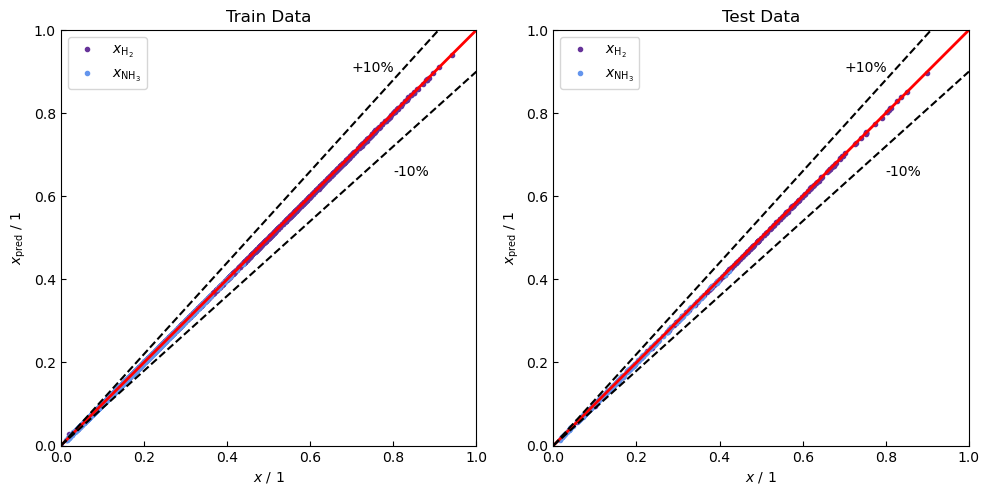

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

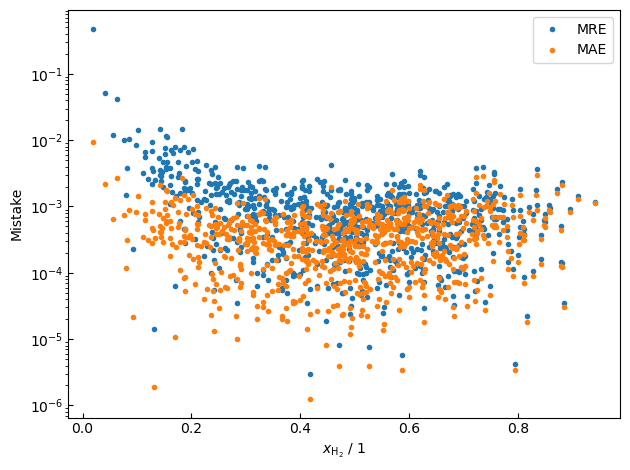

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

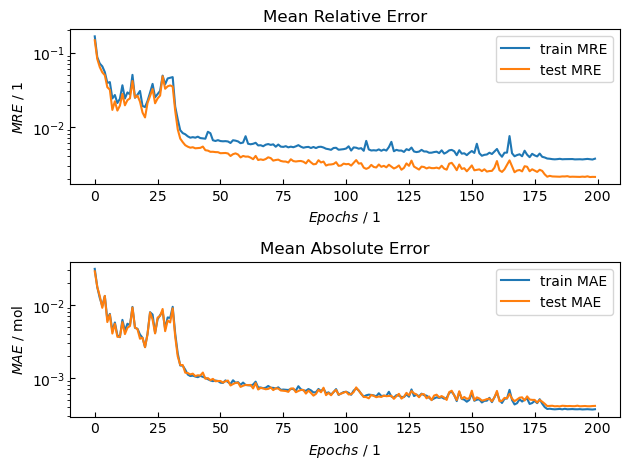

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

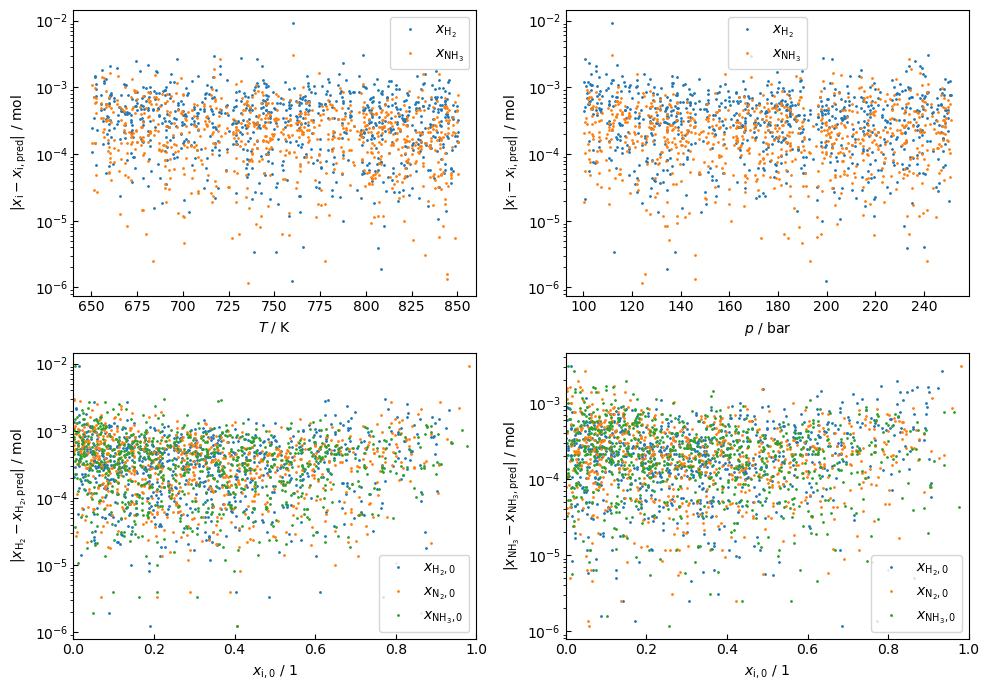

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

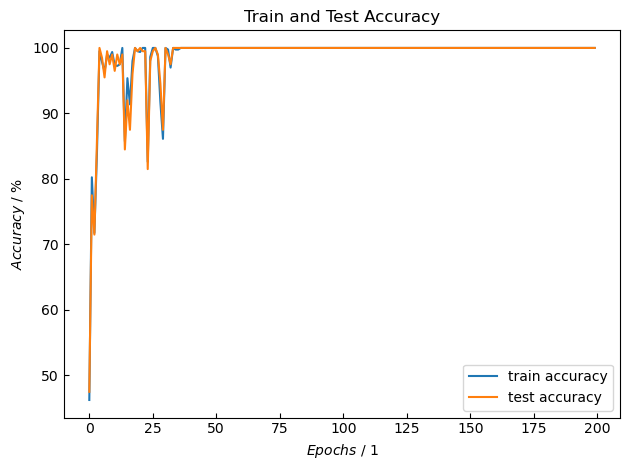

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.4611e+00, -6.2894e-01,  6.1497e-01,  2.1644e-01, -8.2474e-01],
        [-1.5360e+00, -1.7099e+00, -8.1444e-01, -1.3021e+00,  2.1301e+00],
        [ 4.0981e-01,  1.6669e+00, -1.3793e+00,  1.9584e+00, -6.4803e-01],
        [ 1.5021e+00,  2.8137e-01, -1.3550e+00,  7.8357e-01,  5.2888e-01],
        [ 3.2755e-01,  9.4249e-01, -1.2633e+00,  1.1408e+00,  7.3792e-02],
        [ 1.1604e+00, -3.9216e-01,  2.0512e+00, -7.9406e-01, -1.2014e+00],
        [-3.4351e-01, -7.2208e-01, -1.0479e+00,  1.4754e+00, -4.7957e-01],
        [-2.4932e-01,  7.4298e-01,  3.5740e-01,  4.6301e-02, -3.9807e-01],
        [-6.5081e-01,  1.3536e+00,  2.1032e+00, -1.2638e+00, -7.7232e-01],
        [-1.0617e+00,  1.7020e+00, -1.0571e+00, -1.2347e+00,  2.2994e+00],
        [ 9.0534e-01, -4.7123e-01, -8.3675e-01,  1.2163e+00, -4.2194e-01],
        [-2.5528e-01,  1.5256e+00,  9.4897e-01,  1.9773e-01, -1.1334e+00],
        [ 8.3027e-01, -3.1979e-01,  1.1492e+00, -1.9604e-01, -9.2745e-01],
        [-4.5049e-01, -1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-3.8283e-01, -4.4894e-02, -1.1493e-01, -2.7577e-01, -1.2646e-01],
         [-1.9531e-01,  6.8674e-02, -8.3493e-02, -7.7684e-02,  3.5496e-01],
         [ 2.7688e-01, -3.5000e-01, -3.7662e-01, -2.9843e-01, -1.0708e-01],
         [ 2.5219e-01,  2.2055e-01,  9.7279e-02,  4.5395e-02,  1.5125e-01],
         [-1.8162e-01, -3.8607e-02,  3.1972e-01,  4.5280e-01,  3.4662e-01],
         [-3.0035e-01, -2.5055e-01,  3.4313e-01, -3.1915e-01, -5.3734e-02],
         [-2.0675e-01, -2.3906e-01, -1.5632e-01,  2.1078e-01, -2.3425e-01],
         [-2.5325e-01, -1.9785e-01, -1.7445e-01,  1.9099e-01,  2.0042e-01],
         [ 1.4362e-01, -1.7652e-01, -5.2872e-02, -3.9421e-01, -2.0256e-01],
         [ 6.5449e-02, -1.5474e-01, -8.2476e-02, -1.7399e-01, -1.4548e-01],
         [-3.3754e-01,  2.8146e-02,  2.9331e-01,  3.2650e-01,  3.5191e-01],
         [-4.1909e-01,  1.1705e-01, -2.3566e-01, -1.2748e-01,  3.4891e-02],
         [ 1.0876e-01, -6.5866e-02,  1.5171e-01,  1.6455e-01, -2.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.5326, 0.9031, 0.0022, 0.2441, 0.2257],
        [0.1238, 0.2527, 0.2727, 0.2678, 0.5569]])
tensor([[-0.0235, -0.0751],
        [ 0.0753,  0.1708]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 9.0272e-01,  5.9305e-01, -4.0910e-01,  8.7522e-01, -4.9306e-01],
        [ 9.0468e-01, -9.3573e-01, -1.0592e+00,  2.1913e+00, -1.2002e+00],
        [-5.2920e-01,  7.3617e-02, -6.5247e-02, -9.8140e-01,  1.0671e+00],
        [-1.3295e+00, -1.4094e+00,  1.4341e+00, -1.0822e+00, -3.0127e-01],
        [ 5.4274e-01,  9.8198e-02, -1.3514e+00,  2.0746e+00, -7.9419e-01],
        [-5.9063e-01,  2.1214e-01, -1.0108e+00,  1.9327e+00, -9.8341e-01],
        [ 1.3765e+00, -8.7062e-04,  8.6525e-01, -1.3326e+00,  5.1291e-01],
        [ 1.5271e+00, -1.7150e+00,  1.0885e+00,  2.4686e-01, -1.3205e+00],
        [ 1.7713e-01,  8.7653e-01,  1.6793e+00, -1.3349e+00, -2.8365e-01],
        [ 5.7882e-01,  3.0823e-01,  1.2383e+00, -5.9310e-01, -6.0910e-01],
        [ 9.3733e-01,  1.6968e+00, -8.7614e-01,  1.1691e+00, -3.3504e-01],
        [ 1.2845e+00, -1.6850e+00,  7.3213e-01, -1.1466e+00,  4.5340e-01],
        [-1.1089e+00,  1.5590e+00, -5.5346e-01, -3.2697e-01,  8.7735e-01],
        [ 1.0652e+00,  7.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()